# **Implementing sequence-to-sequence model with attention**
- Please make sure you use GPU by setting the menu: Runtime > change runtime type > GPU

## **Preparing Data**

In [1]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!python -m spacy download en
!python -m spacy download de

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7 python3.7-minimal
0 upgraded, 6 newly installed, 0 to remove and 6 not upgraded.
Need to get 4,698 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.7-minimal amd64 3.7.17-1+jammy1 [608 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.7-minimal amd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

from gensim.models import KeyedVectors

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

We use Field library to process data. By setting batch_first = True, we set the batch dimension comes first.

In [5]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

We use Multi30k dataset of about 30k English, Deutch, and French sentences, and each sentence has 12 words. We set exts as the langauges for source and target languages.

In [6]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

In [7]:
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.de.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.de.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.de.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.en.gz -P ./data/multi30k

--2023-11-14 13:52:53--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.de.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 637044 (622K) [application/octet-stream]
Saving to: ‘./data/multi30k/train.de.gz’

train.de.gz         100%[===================>] 622.11K  --.-KB/s    in 0.02s   

2023-11-14 13:52:54 (32.2 MB/s) - ‘./data/multi30k/train.de.gz’ saved [637044/637044]

--2023-11-14 13:52:54--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, await

In [8]:
!gzip -d ./data/multi30k/train.de.gz
!gzip -d ./data/multi30k/train.en.gz
!gzip -d ./data/multi30k/val.de.gz
!gzip -d ./data/multi30k/val.en.gz
!gzip -d ./data/multi30k/test_2016_flickr.en.gz
!gzip -d ./data/multi30k/test_2016_flickr.de.gz

In [9]:
!mv ./data/multi30k/test_2016_flickr.de ./data/multi30k/test2016.de
!mv ./data/multi30k/test_2016_flickr.en ./data/multi30k/test2016.en

In [10]:
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG), root = './data')

In [11]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [12]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


## **Build Vocabulary**
- We use `build_vocab` function to get indexing of tokens. Note that the vocabularies of source and target are different.
- We use `min_freq` to have words that appear at least twice in the corpus to add to the vocabulary. So the word that apears only once will convert to <unk> token.
- Note that we have to use only training set to build the vocabulary, neither validation nor test set.

In [13]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [14]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [15]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
print(device)

cuda


In [17]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

In [18]:
next(iter(train_iterator))


[torchtext.data.batch.Batch of size 128 from MULTI30K]
	[.src]:[torch.cuda.LongTensor of size 128x23 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 128x21 (GPU 0)]

## **Building the Model**

### Encoder

In [19]:
class LSTM_Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, bidirectional=False, pretrained_embeddings = None):
        super().__init__()

        ## TODO: define your model here

        self.embeddings = nn.Embedding(vocab_size, embed_size)

        if pretrained_embeddings is not None:
          self.embeddings.weight.data.copy_(torch.from_numpy(pretrained_embeddings.vector))

        self.lstm = nn.LSTM(embed_size, hidden_size,
                            bidirectional = bidirectional, num_layers = num_layers, dropout = dropout, batch_first = True)
        self.dropout = nn.Dropout(dropout)

        self.bidirectional = bidirectional
        self.num_layers = num_layers

        if bidirectional:
          self.projection1 = nn.Linear(hidden_size * 2, hidden_size)
          self.projection2 = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, x):

        ## TODO: write down the forward step
        # x shape: [batch_size, seq_len]

        embed = self.dropout(self.embeddings(x)) # [batch_size, seq_len, hidden_size]
        output, (hidden, cell) = self.lstm(embed)

        # output: [batch_size, seq_len, hidden_size * num_directions],
        # hidden: [num_directions * num_layers, batch_size, hidden_size],
        # cell: [num_directions * num_layers, batch_size, hidden_size]]


        if self.bidirectional:

          output = torch.tanh(self.projection1(output)) # [batch_size, seq_len, hidden_size]

          hidden = self.projection2(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)) # contact the last forward and backward hidden states
          hidden = torch.tanh(hidden) # nonlinearity

          # hidden: [batch_size, hidden_size]

          cell = self.projection2(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim = 1)) # contact the last forward and backward cell states
          cell = torch.tanh(cell) # nonlinearity

          # cell: [batch_size, hidden_size]
          return output, hidden.unsqueeze(0), cell.unsqueeze(0)

        return output, hidden, cell

### Decoder with attention

In [20]:
class Attention(nn.Module):
    def __init__(self, hidden_size, attention_type = 'vanilla'):
        super().__init__()

        self.attention_type = attention_type
        self.softmax = nn.Softmax(dim=1)

        if attention_type == 'additive':
          self.projection = nn.Linear(hidden_size * 2, hidden_size, bias=False)
          self.v = nn.Linear(hidden_size, 1, bias = False)

    def forward(self, decoder_hidden, enc_states, mask):

        # decoder_hidden: [batch_size, hidden_size]
        # enc_states: [batch_size, seq_len, hidden_size]

        if self.attention_type == 'vanilla':
          decoder_hidden = decoder_hidden.unsqueeze(2)
          attention_values = torch.bmm(enc_states, decoder_hidden).squeeze(2) # [batch_size, seq_len, hidden_size] x [batch_size, hidden_size, 1] -> [batch_size, seq_len, 1]
          attention_values = attention_values.masked_fill(mask == 0, -1e10) # [batch_size, seq_len]

        elif self.attention_type == 'additive':
          src_length = enc_states.shape[1]
          decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_length, 1) # [batch_size, seq_len, hidden_size]
          attention_values = self.v(torch.tanh(self.projection(torch.cat((decoder_hidden, enc_states), dim = 2)))).squeeze(2)
          attention_values = attention_values.masked_fill(mask == 0, -1e10) # [batch_size, seq_len]

        return self.softmax(attention_values)

In [21]:
class LSTM_Decoder(nn.Module):
    def __init__(self, output_dim, embed_size, hidden_size, num_layers, attention, dropout, pretrained_embeddings = None):
        super().__init__()

        ## TODO: define your model here

        self.output_dim = output_dim
        self.num_layers = num_layers
        self.attention = attention
        self.embeddings = nn.Embedding(output_dim, embed_size)

        if pretrained_embeddings is not None:
          self.embeddings.weight.data.copy_(torch.from_numpy(pretrained_embeddings.vector))


        self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size,
                            num_layers = num_layers, dropout=dropout, batch_first = True)
        self.fc_out = nn.Linear(hidden_size * 2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell, enc_states, mask):

        ## TODO: write down the forward step
        last_hidden = hidden[-1]
        embed = self.dropout(self.embeddings(x.unsqueeze(1))) # [batch_size, 1, hidden_size]
        # attention distribution
        attention_dist = self.attention(last_hidden, enc_states, mask).unsqueeze(1) # [batch_size, 1, seq_len]

        # context vector
        context = torch.bmm(attention_dist, enc_states) # [batch_size, 1, seq_len] x [batch_size, seq_len, hidden_size] -> [batch_size, 1, hidden_size]
        rnn_input = torch.cat((embed, context), dim = 2) # [batch_size, 1, hidden_size + embed_size]

        if hidden.shape[0] != self.num_layers:
          hidden = hidden.repeat(self.num_layers, 1, 1) # replicate last encoder hidden
          cell = cell.repeat(self.num_layers, 1, 1) # replicate las cell hidden

        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell)) # output shape: [batch_size, 1, hidden_size]
        output, context = output.squeeze(1), context.squeeze(1)
        output = self.fc_out(torch.cat((output, context), dim = 1))

        return output, hidden, cell, attention_dist.squeeze(1)

### Sequence-to-sequence model

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def generate_mask(self, src):
        mask = (src != self.src_pad_idx)
        return mask

    def forward(self, src, trg, teacher_forcing_ratio=0.7):

        src = src
        trg = trg

        ## TODO: write down the forward step
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_output_dim = self.decoder.output_dim


        predictions = torch.zeros(trg_len, batch_size, trg_output_dim).to(self.device)
        enc_states, hidden, cell = self.encoder(src)

        trg = trg.transpose(0,1)
        mask = self.generate_mask(src)
        # first input is the <sos> token
        input = trg[0,:]

        for idx in range(1, trg_len):

            output, hidden, cell, attention = self.decoder(input, hidden, cell, enc_states, mask)
            predictions[idx] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top = output.argmax(1)
            input = trg[idx] if teacher_force else top

        return predictions, attention

### Training the Seq2Seq Model

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
print(INPUT_DIM)
print(OUTPUT_DIM)
# define your hyperparameters here

embed_size = 128
hidden_size = 256
num_layers = 1
dropout = 0.1
bidirectional = False

attention = Attention(hidden_size, 'vanilla')
enc = LSTM_Encoder(INPUT_DIM, embed_size, hidden_size, num_layers, dropout, bidirectional)
dec = LSTM_Decoder(OUTPUT_DIM, embed_size, hidden_size, num_layers, attention, dropout)

7853
5893


In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [ ]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        predictions, _ = model(src, trg)
        output_dim = predictions.shape[-1]

        trg = trg.transpose(0,1)
        trg = trg[1:].reshape(-1)
        preds = predictions[1:].reshape(-1, output_dim)
        loss = criterion(preds, trg)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here

            predictions,_ = model(src, trg, 0) # no teacher forcing as we are in eval mode
            output_dim = predictions.shape[-1]
            preds = predictions[1:].reshape(-1, output_dim)

            trg = trg.transpose(0,1)
            trg = trg[1:].reshape(-1)

            loss = criterion(preds, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [ ]:
device

device(type='cuda')

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 39s
	Train Loss: 5.385
	 Val. Loss: 4.917
Epoch: 02 | Time: 0m 39s
	Train Loss: 4.612
	 Val. Loss: 5.020
Epoch: 03 | Time: 0m 41s
	Train Loss: 4.300
	 Val. Loss: 4.951
Epoch: 04 | Time: 0m 39s
	Train Loss: 4.038
	 Val. Loss: 4.848
Epoch: 05 | Time: 0m 39s
	Train Loss: 3.872
	 Val. Loss: 4.877
Epoch: 06 | Time: 0m 39s
	Train Loss: 3.738
	 Val. Loss: 4.810
Epoch: 07 | Time: 0m 38s
	Train Loss: 3.610
	 Val. Loss: 4.641
Epoch: 08 | Time: 0m 41s
	Train Loss: 3.466
	 Val. Loss: 4.523
Epoch: 09 | Time: 0m 38s
	Train Loss: 3.298
	 Val. Loss: 4.478
Epoch: 10 | Time: 0m 38s
	Train Loss: 3.198
	 Val. Loss: 4.340


In [ ]:
# model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 4.322


### Inference and attention visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 20):

    model.eval()

    # TODO: write your code
    # Add start and end tokens to the source sentence
    src_tokens = sentence.copy()
    src_tokens.insert(0, src_field.init_token)
    src_tokens.append(src_field.eos_token)

    token_indices = [src_field.vocab.stoi[token] for token in src_tokens]
    src = torch.LongTensor(token_indices).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs_encoder, hidden, cell = model.encoder(src)

    mask = model.generate_mask(src)

    trg_indices = [trg_field.vocab.stoi["<sos>"]]
    decoder_attentions = torch.zeros(max_len, 1, len(token_indices)).to(device)
    for i in range(max_len):
        trg_w = torch.LongTensor([trg_indices[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell, attention = model.decoder(
                trg_w, hidden, cell, outputs_encoder, mask
            )
        decoder_attentions[i] = attention
        best_guess = output.argmax(1)

        trg_indices.append(best_guess)

        if output.argmax(1) == trg_field.vocab.stoi["<eos>"]:
            break

    decoded_words = [trg_field.vocab.itos[idx] for idx in trg_indices]
    decoded_words = decoded_words[1:]
    decoder_attentions = decoder_attentions[:len(trg_indices)-1]
    return decoded_words, decoder_attentions.cpu()

In [ ]:
def display_attention(sentence, translation, attention):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(6,8))

    ax = fig.add_subplot(111)

    cax = ax.matshow(attention.squeeze(1).numpy(), cmap='bone')

    # Set up axes
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
    ax.set_yticklabels(['']+translation)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()



## Example 1

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['the', 'brown', 'dog', 'and', 'white', 'dog', 'is', 'playing', '.', '<eos>']


<ipython-input-196-fc7bbcf42805>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-196-fc7bbcf42805>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


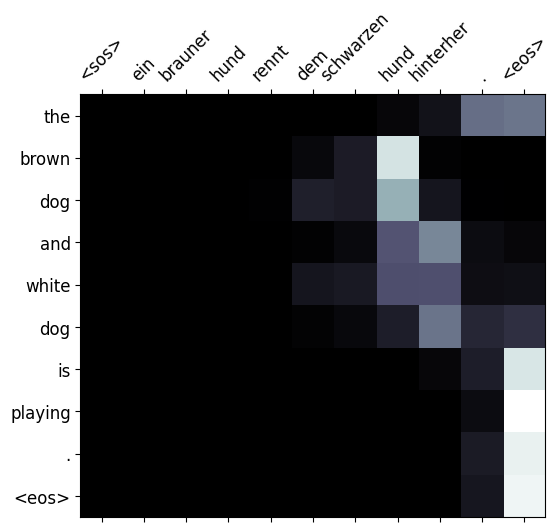

In [ ]:
display_attention(src, translation, attention)

## Example 2

In [ ]:
example_idx = 1

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'mann', 'schläft', 'in', 'einem', 'grünen', 'raum', 'auf', 'einem', 'sofa', '.']
trg = ['a', 'man', 'sleeping', 'in', 'a', 'green', 'room', 'on', 'a', 'couch', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'playing', 'a', 'a', '.', '.', '<eos>']


<ipython-input-196-fc7bbcf42805>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-196-fc7bbcf42805>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


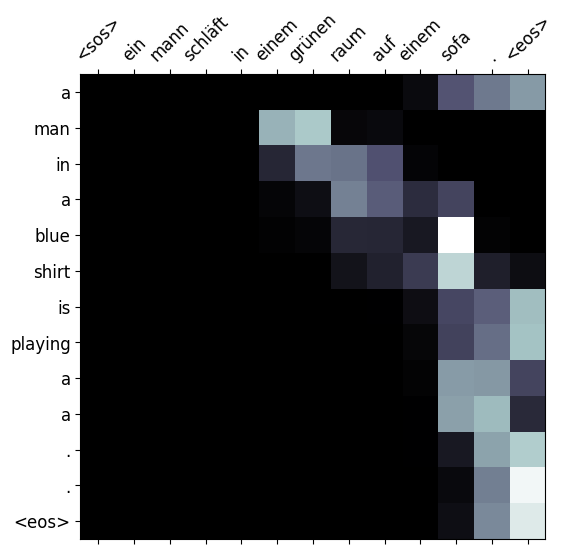

In [ ]:
display_attention(src, translation, attention)

## Example 3

In [ ]:
example_idx = 3

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['zwei', 'männer', 'bauen', 'eine', 'blaue', 'eisfischerhütte', 'auf', 'einem', 'zugefrorenen', 'see', 'auf']
trg = ['two', 'men', 'setting', 'up', 'a', 'blue', 'ice', 'fishing', 'hut', 'on', 'an', 'iced', 'over', 'lake']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['two', 'men', 'in', 'a', 'red', ',', 'one', 'is', 'on', 'a', 'dirt', '.', '<eos>']


<ipython-input-196-fc7bbcf42805>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-196-fc7bbcf42805>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


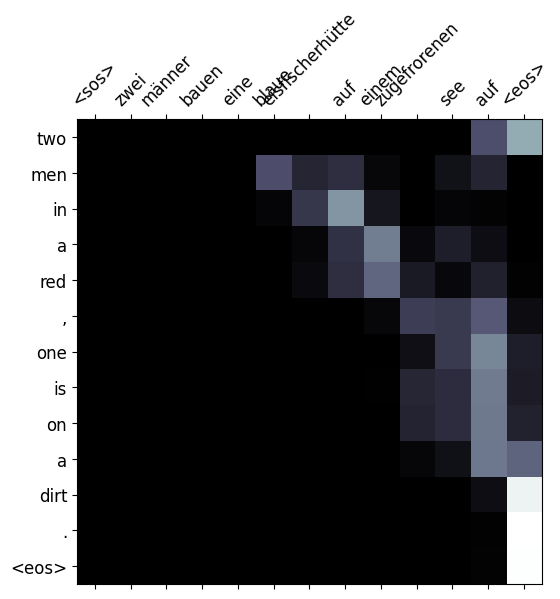

In [ ]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 10.09


## Tuned Seq2Seq Model with Attention

In [ ]:
embed_size = 256
hidden_size = 512
num_layers = 2
dropout = 0.1
bidirectional = False

attention = Attention(hidden_size, 'vanilla')
enc = LSTM_Encoder(INPUT_DIM, embed_size, hidden_size, num_layers, dropout, bidirectional)
dec = LSTM_Decoder(OUTPUT_DIM, embed_size, hidden_size, num_layers, attention, dropout)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

tuned_model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

tuned_model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(tuned_model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(tuned_model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(tuned_model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(tuned_model.state_dict(), 'my-tuned-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 53s
	Train Loss: 5.171
	 Val. Loss: 5.098
Epoch: 02 | Time: 0m 54s
	Train Loss: 4.556
	 Val. Loss: 4.894
Epoch: 03 | Time: 0m 53s
	Train Loss: 4.137
	 Val. Loss: 4.857
Epoch: 04 | Time: 0m 52s
	Train Loss: 3.894
	 Val. Loss: 4.819
Epoch: 05 | Time: 0m 54s
	Train Loss: 3.711
	 Val. Loss: 4.734
Epoch: 06 | Time: 0m 53s
	Train Loss: 3.518
	 Val. Loss: 4.676
Epoch: 07 | Time: 0m 53s
	Train Loss: 3.320
	 Val. Loss: 4.590
Epoch: 08 | Time: 0m 52s
	Train Loss: 3.142
	 Val. Loss: 4.501
Epoch: 09 | Time: 0m 53s
	Train Loss: 2.946
	 Val. Loss: 4.325
Epoch: 10 | Time: 0m 54s
	Train Loss: 2.792
	 Val. Loss: 4.216


In [ ]:
from torchtext.data.metrics import bleu_score

bleu_score = calculate_bleu(test_data, SRC, TRG, tuned_model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 13.44


## Bidirectional Se2Seq LSTM with Attention

In [ ]:
embed_size = 256
hidden_size = 512
num_layers = 2
dropout = 0.1
bidirectional = True

attention = Attention(hidden_size, 'vanilla')
enc = LSTM_Encoder(INPUT_DIM, embed_size, hidden_size, num_layers, dropout, bidirectional)
dec = LSTM_Decoder(OUTPUT_DIM, embed_size, hidden_size, num_layers, attention, dropout)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

bidirectional_lstm_enc_model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

bidirectional_lstm_enc_model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(bidirectional_lstm_enc_model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(bidirectional_lstm_enc_model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(bidirectional_lstm_enc_model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bidirectional_lstm_enc_model.state_dict(), 'bidirectional_lstm_enc_model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 1m 4s
	Train Loss: 5.121
	 Val. Loss: 5.065
Epoch: 02 | Time: 1m 5s
	Train Loss: 4.520
	 Val. Loss: 5.311
Epoch: 03 | Time: 1m 0s
	Train Loss: 4.194
	 Val. Loss: 5.280
Epoch: 04 | Time: 1m 0s
	Train Loss: 3.986
	 Val. Loss: 5.073
Epoch: 05 | Time: 1m 2s
	Train Loss: 3.796
	 Val. Loss: 4.742
Epoch: 06 | Time: 0m 59s
	Train Loss: 3.607
	 Val. Loss: 4.761
Epoch: 07 | Time: 1m 0s
	Train Loss: 3.412
	 Val. Loss: 4.575
Epoch: 08 | Time: 1m 1s
	Train Loss: 3.207
	 Val. Loss: 4.464
Epoch: 09 | Time: 1m 1s
	Train Loss: 3.003
	 Val. Loss: 4.348
Epoch: 10 | Time: 1m 1s
	Train Loss: 2.829
	 Val. Loss: 4.131


In [ ]:
from torchtext.data.metrics import bleu_score

bleu_score = calculate_bleu(test_data, SRC, TRG, bidirectional_lstm_enc_model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 16.42


## Seq2Seeq LSTM Model with Additive Attention

In [ ]:
embed_size = 128
hidden_size = 256
num_layers = 1
dropout = 0.1
bidirectional = False

attention = Attention(hidden_size, 'additive')
enc = LSTM_Encoder(INPUT_DIM, embed_size, hidden_size, num_layers, dropout, bidirectional)
dec = LSTM_Decoder(OUTPUT_DIM, embed_size, hidden_size, num_layers, attention, dropout)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

additive_attn_model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

additive_attn_model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(additive_attn_model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(additive_attn_model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(additive_attn_model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(additive_attn_model.state_dict(), 'additive_attn_model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 41s
	Train Loss: 5.340
	 Val. Loss: 4.888
Epoch: 02 | Time: 0m 40s
	Train Loss: 4.627
	 Val. Loss: 4.982
Epoch: 03 | Time: 0m 40s
	Train Loss: 4.321
	 Val. Loss: 4.932
Epoch: 04 | Time: 0m 42s
	Train Loss: 4.104
	 Val. Loss: 4.970
Epoch: 05 | Time: 0m 41s
	Train Loss: 3.955
	 Val. Loss: 4.869
Epoch: 06 | Time: 0m 41s
	Train Loss: 3.806
	 Val. Loss: 4.860
Epoch: 07 | Time: 0m 40s
	Train Loss: 3.676
	 Val. Loss: 4.876
Epoch: 08 | Time: 0m 40s
	Train Loss: 3.540
	 Val. Loss: 4.767
Epoch: 09 | Time: 0m 40s
	Train Loss: 3.432
	 Val. Loss: 4.646
Epoch: 10 | Time: 0m 42s
	Train Loss: 3.276
	 Val. Loss: 4.546


In [ ]:
from torchtext.data.metrics import bleu_score

bleu_score = calculate_bleu(test_data, SRC, TRG, additive_attn_model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 8.38
